In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from sklearn.preprocessing import RobustScaler
from google.cloud import bigquery
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import warnings
warnings.filterwarnings('ignore')

sql = """
    SELECT
      date,
      SUM(impressions) AS imps,
      SUM(clicks) AS clicks,
      AVG(position) AS avg_pos,
      country,
      device
    FROM
      `api-project-901373404215.gsc.gsc_web_totals`
    WHERE
      date BETWEEN '2020-01-01' AND '2021-03-31'
    GROUP BY
      date,
      country,
      device
    """

bq_client = bigquery.Client()

df = bq_client.query(sql).to_dataframe()
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(
    by='date',
    ascending=False) \
    .reset_index(drop=True)

df.head()

,date,imps,clicks,avg_pos,country,device
0,2021-03-31,3,0,5.000,ata,TABLET
1,2021-03-31,2769,68,14.782,cym,DESKTOP
2,2021-03-31,2945,46,21.512,blz,DESKTOP
3,2021-03-31,1888,38,22.677,btn,DESKTOP
4,2021-03-31,1682,34,20.433,grd,DESKTOP


In [2]:
aggs = {
    'imps':'sum',
    'clicks':'sum',
    'avg_pos':'mean'
}

df = df.groupby(
    'date'
    ).agg(aggs).reset_index()

# Calculate ctr
df['ctr'] = (df['clicks'] / df['imps']) * 100

# Change column names
df = df.rename(
    columns={
        'imps': 'total_imps',
        'clicks': 'total_clicks',
        'avg_pos': 'total_avg_pos',
        'ctr': 'total_ctr'
    }
)

# Re-sort
df = df.sort_values(
    by='date',
    ascending=True
).reset_index(drop=True)

df

,date,total_imps,total_clicks,total_avg_pos,total_ctr
0,2020-01-01,82508526,1719166,15.261,2.084
1,2020-01-02,93578249,2037771,14.660,2.178
2,2020-01-03,91752406,1927190,14.942,2.100
3,2020-01-04,88872234,1807605,15.360,2.034
4,2020-01-05,91827252,1968473,15.295,2.144
...,...,...,...,...,...
451,2021-03-27,80373435,1583778,16.636,1.971
452,2021-03-28,84754294,1798429,16.564,2.122
453,2021-03-29,96580399,2127235,15.870,2.203
454,2021-03-30,92635773,2009864,16.269,2.170


In [3]:
# Create the weekday and weekend dayparts

# Create a weekpart column
df['weekpart'] = df['date'].dt.weekday

conditions = [
    (df['weekpart'] >= 5),
    (df['weekpart'] < 5)
]

choices = [
    'weekend',
    'weekday'
]

df['weekpart'] = np.select(
    conditions,
    choices
)

print(df.shape)
df.head(7)

(456, 6)


,date,total_imps,total_clicks,total_avg_pos,total_ctr,weekpart
0,2020-01-01,82508526,1719166,15.261,2.084,weekday
1,2020-01-02,93578249,2037771,14.660,2.178,weekday
2,2020-01-03,91752406,1927190,14.942,2.100,weekday
3,2020-01-04,88872234,1807605,15.360,2.034,weekend
4,2020-01-05,91827252,1968473,15.295,2.144,weekend
5,2020-01-06,95877965,2112230,15.075,2.203,weekday
6,2020-01-07,97938423,2165590,15.084,2.211,weekday


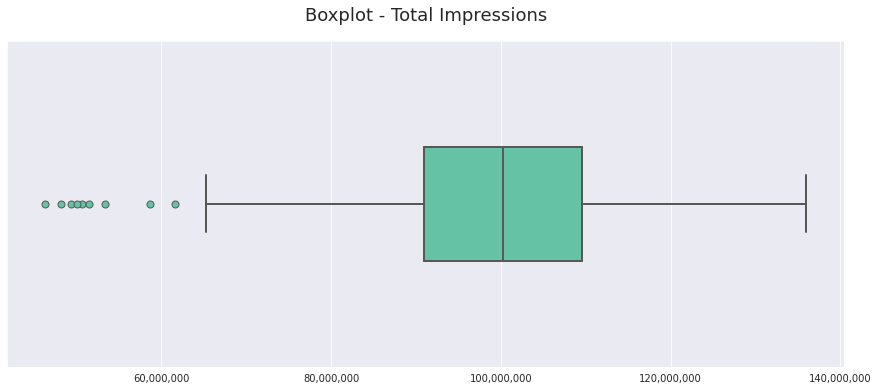

In [4]:
# Box plot
fig, ax = plt.subplots(figsize=(15, 6))

secondary_color = '#585858'
palette = plt.get_cmap('Set2')
num = 0

# Create the plot
y = df['total_imps']

# Change the style of fliers and their fill
flierprops = dict(
    marker='o',
    markerfacecolor=palette(num),
    markersize=7,
    markeredgecolor=secondary_color
)

bp = ax.boxplot(
    y,
    patch_artist=True,
    vert=False,
    flierprops=flierprops,
    widths=.35
)

# Remove y axis ticks
ax.axes.get_yaxis().set_visible(False)

# Add a title
title = 'Boxplot - Total Impressions'
ax.set_title(
    title,
    fontdict={'fontsize': 18},
    pad=20
)

# Change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # Change outline color
    box.set(color=secondary_color, linewidth=2)
    # Change fill color
    box.set(facecolor=palette(num))

# Change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color=secondary_color, linewidth=2)

# Change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color=secondary_color, linewidth=2)

# Change color and linewidth of the medians
for median in bp['medians']:
    median.set(color=secondary_color, linewidth=2)
    
# Prevent scientific notation on the y axis
ax.get_xaxis().get_major_formatter().set_scientific(False)

# Format the y axis to have commas
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

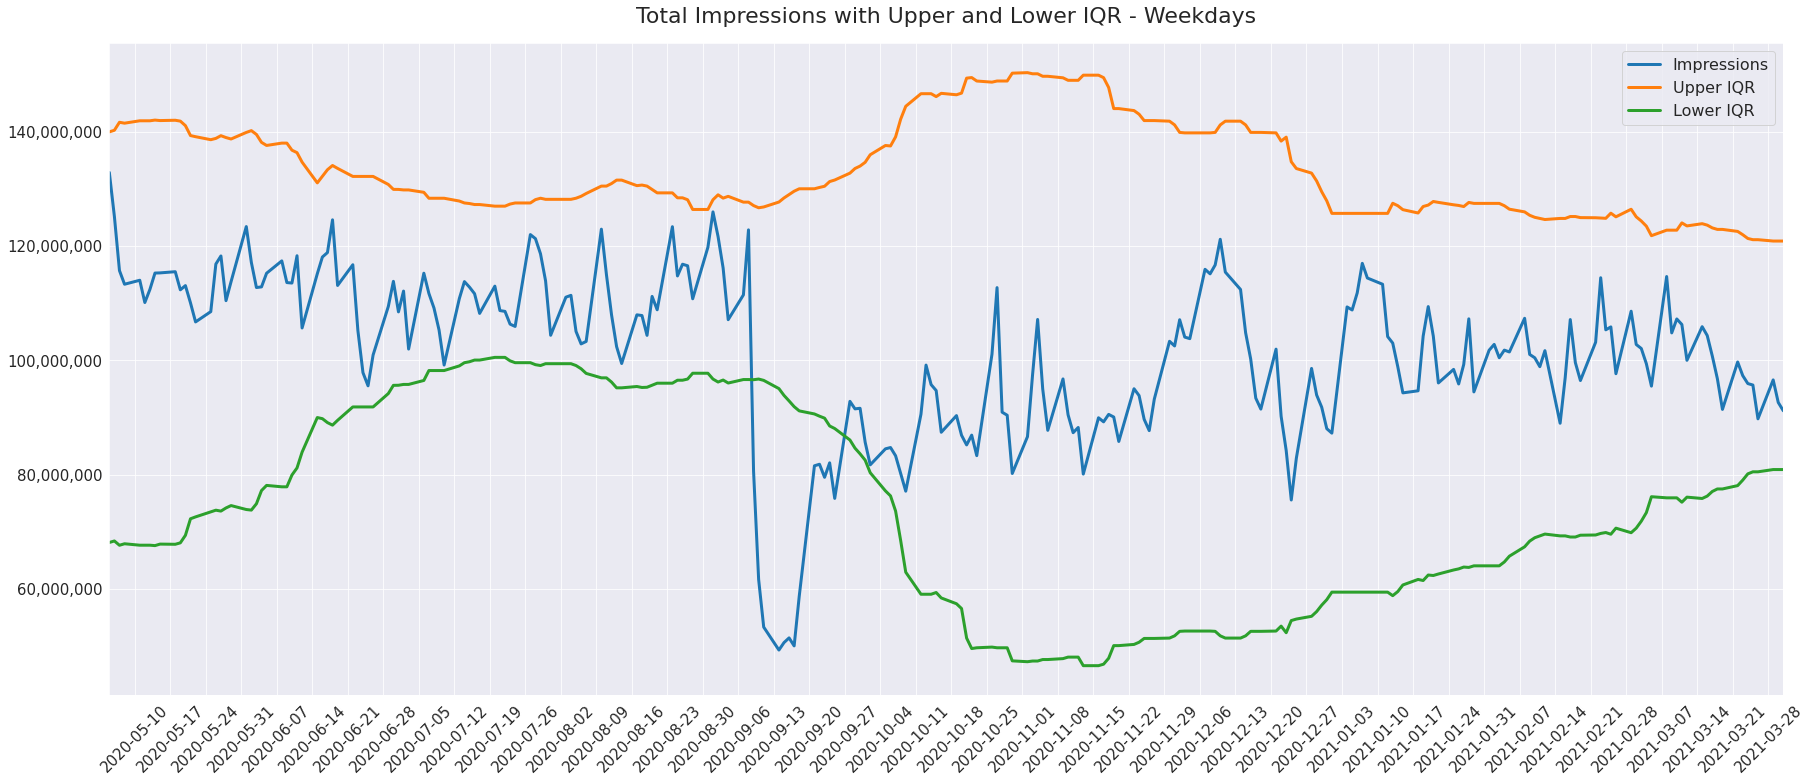

In [6]:
# For demonstration purposes graph the total impressions by day with the IQR upper an lower bounds
# Weekdays only
df_wkday = df.loc[df['weekpart'] == 'weekday']

# Get the 90 day rolling 25th and 75th percentiles for the impressions
df_wkday['rolling_75'] = df_wkday['total_imps'].rolling(window=90).apply(lambda x: np.quantile(x, 0.75))
df_wkday['rolling_25'] = df_wkday['total_imps'].rolling(window=90).apply(lambda x: np.quantile(x, 0.25))

# Calculate the interquartile range
df_wkday['iqr'] = df_wkday['rolling_75'] - df_wkday['rolling_25']

# Get the upper and lower bounds. Anything that falls outside these values is an oultier
# 1.5 is the standard value but you can adjust this to your data/needs
df_wkday['iqr_upper'] = df_wkday['rolling_75'] + (df_wkday['iqr'] * 1.5)
df_wkday['iqr_lower'] = df_wkday['rolling_25'] - (df_wkday['iqr'] * 1.5)

# Filter for only the columns we want to chart
df_plot = df_wkday[[
    'date',
    'total_imps',
    'iqr_upper',
    'iqr_lower'
]]

df_plot = df_plot.dropna()

# Create the chart
fig, ax = plt.subplots(figsize=(30, 12))

# Set the x axis limits
min_date = df_plot['date'].min()
max_date = df_plot['date'].max()

x = df_plot['date']
y = df_plot['total_imps']
y1 = df_plot['iqr_upper']
y2 = df_plot['iqr_lower']

ax.plot(
    x,
    y,
    label='Impressions',
    linewidth=3.0
)

ax.plot(
    x,
    y1,
    label='Upper IQR',
    linewidth=3.0
)

ax.plot(
    x,
    y2,
    label='Lower IQR',
    linewidth=3.0
)

# Set the x axis limits
ax.set_xlim([
    min_date,
    max_date]
)

# Set the tick frequency and for the dates and rotate
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_tick_params(rotation=45)

ax.tick_params(
    axis='both',
    which='major',
    labelsize=15
)

# Add a legend
ax.legend(
    loc='upper right',
    fontsize=16
)

# Add a title
title = 'Total Impressions with Upper and Lower IQR - Weekdays'
ax.set_title(
    title,
    fontdict={'fontsize': 22},
    pad=20
)

# Prevent scientific notation on the y axis
ax.get_yaxis().get_major_formatter().set_scientific(False)

# Format the y axis to have commas
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

- Adjust the period for whatever works best for you
    - For example, you can see after the big drop in early september, the iqr increases a lot after that since it's based on the past 90 days, you may want to shorten/lengthen that time frame

### Calculate the IQR distance
- The IQR distance is calculated by normalizing the metric by subtracting the median (instead of the mean) and scaling according to the IQR. So basically a robust z score scaled to the IQR
- This is done because outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the IQR often give better results
- Scikit-learn's Robust Scaler implements this but I'll show how to calculate it manually if you don't want another library to import

In [44]:
# Scikit-learn way
iqr = RobustScaler()

# Looking at weekdays only
df_wkday = df.loc[df['weekpart'] == 'weekday']

# Filter for the past 90 days, otherwise it will calculate it over the whole dataset. I don't know if it's possible to implement this as a rolling function
df_wkday = df_wkday.loc[df_wkday['date'].isin(df_wkday['date'].tolist()[-90:])].reset_index(drop=True)

df_wkday['iqr_value_sklearn'] = iqr.fit_transform(df_wkday['total_imps'].values.reshape(-1, 1))

# Manual calculation

# Get the 25th and 75th percentile
df_wkday['75'] = df_wkday['total_imps'].quantile(0.75)
df_wkday['25'] = df_wkday['total_imps'].quantile(0.25)

# Get the iqr
df_wkday['iqr'] = df_wkday['75'] - df_wkday['25']

# Scale to the iqr
df_wkday['iqr_value_manual'] = (df_wkday['total_imps'] - df_wkday['total_imps'].median()) / df_wkday['iqr']

df_wkday[[
    'date',
    'total_imps',
    'iqr_value_sklearn',
    'iqr_value_manual'
]].tail()

,date,total_imps,iqr_value_sklearn,iqr_value_manual
85,2021-03-25,95683991,-0.557,-0.557
86,2021-03-26,89768490,-1.149,-1.149
87,2021-03-29,96580399,-0.468,-0.468
88,2021-03-30,92635773,-0.862,-0.862
89,2021-03-31,91171015,-1.009,-1.009
